<a href="https://colab.research.google.com/github/NSArt1/StatPrac25/blob/testbranch/MyPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import torch
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from tqdm import tqdm

import time

Приклеиваем диск


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##PIX2PIX Dataset

In [ ]:
class Pix2PixDataset(data.Dataset):
    def __init__(self, root_dir, transform=None, is_train=True, to_leak = 0, swap = False):
        self.root_dir = root_dir
        self.transform = transform
        self.swap = swap
        self.path_to_train_files = os.path.join(root_dir, 'train')
        self.path_to_val_files = os.path.join(root_dir, 'val')
        if is_train:
          self.path = self.path_to_train_files
          self.files =  os.listdir(self.path_to_train_files)
          if to_leak>0:
            extra = os.listdir(self.path_to_val_files)
            self.files+= extra[:int(to_leak*len(extra))]
        else:
          self.path = self.path_to_val_files
          self.files =  os.listdir(self.path_to_val_files)
          if to_leak>0:
            extra = os.listdir(self.path_to_val_files)
            self.files= extra[int(to_leak*len(extra)):]
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.path,self.files[idx]))
        img = np.array(img)

        x, y = np.split(img, 2, axis=1)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        if self.swap:
          return y,x

        return  x,y

    def __len__(self):
        return len(self.files)

In [ ]:
class Pix2PixDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, is_train=True):
        self.root_dir = root_dir
        self.transform = transform

        self.path_to_train_files = os.path.join(root_dir, 'train')
        self.path_to_val_files = os.path.join(root_dir, 'val')

        train_path, _, train_files = list(os.walk(self.path_to_train_files))[0]
        train_files = [os.path.join(train_path, file) for file in train_files]
        val_path, _, val_files = list(os.walk(self.path_to_val_files))[0]
        val_files = [os.path.join(val_path, file) for file in val_files]

        self.files = train_files + val_files
        # print(self.files)
        self.files = self.files[:-16] if is_train else self.files[-16:]

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img = np.array(img)

        x, y = np.split(img, 2, axis=1)

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)

        return  x,y

    def __len__(self):
        return len(self.files)

# MODEL


In [ ]:
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), ##doesnt change HxW, only add channels
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        res = self.conv_block(x)
        x = self.maxpool(res)
        x = self.dropout(x)

        return res, x

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dropout = nn.Dropout(dropout)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels // 2, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, y):
        x = self.upsample(x)
        x = self.dropout(x)
        # print("Inside UpSample: ", x.shape, y.shape)
        x = torch.cat((x, y), dim = 1) #concat by channels
        # print("Inside UpSample: ", x.shape, y.shape)
        x = self.conv_block(x)
        # print("x.shape Inside UpSample: ", x.shape)
        return x

class UNet(nn.Module):
    def __init__(self, depth=5, d=64, dropout=0.1):
        super().__init__()

        self.depth = depth
        self.dropout = dropout

        self.down_depth = depth
        self.up_depth = depth

        down_channels = [3] + [d * 2 ** i for i in range(self.down_depth - 1)] # [3, 64, 128, 256, 512]
        self.down_blocks = nn.ModuleList([
            DownSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(down_channels[:-1], down_channels[1:])
        ])

        up_channels = [d * 2 ** (i - 1) for i in range(self.up_depth, 0, -1)]
        up_channels.append(up_channels[-1]) #[1024, 512, 256, 128, 64, 64]
        self.up_blocks = nn.ModuleList([
            UpSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(up_channels[:-2], up_channels[2:])
        ])

        mid_channels = [down_channels[-1],
                        down_channels[-1] // 2,
                        up_channels[0] // 2]
        self.mid_block = nn.Sequential(
            nn.Conv2d(mid_channels[0], mid_channels[1], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[1]),
            nn.ReLU(),
            nn.Conv2d(mid_channels[1], mid_channels[2], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[2]),
            nn.ReLU(),
        )

        self.conv1x1 = nn.Conv2d(up_channels[-1], 3, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        shortcuts = []
        for i in range(len(self.down_blocks)):
            res, x = self.down_blocks[i](x)
            shortcuts.append(res)
            # print('res_shape: ',res.shape,'x_shape: ', x.shape)

        x = self.mid_block(x)
        # print('mid_x: ',x.shape)

        for i in range(len(self.up_blocks)):
            # print('x exp_shape: ', x.shape, 'res_shape: ', shortcuts[-i-1].shape)
            x = self.up_blocks[i](x, shortcuts[-i - 1])
        x = self.tanh(self.conv1x1(x))

        return x

class ConvBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv_bn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv_bn(x)

class Discriminator(nn.Module):
    def __init__(self, d=32, n_layers=5):
        super().__init__()

        channels = [d * 2 ** i for i in range(n_layers - 1)] + [1]

        self.layers = nn.ModuleList([nn.Conv2d(6, d, 4, 2, 1)] + \
                                    [ConvBN(in_c, out_c) for in_c, out_c in zip(channels[:-1], channels[1:])])

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        x = torch.cat((x, y), 1)

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.leaky_relu(x)

        return self.sigmoid(x)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


class Pix2pix(nn.Module):
    def __init__(self, alpha=100.0, max_lr=1e-3):
        super().__init__()

        self.generator = UNet()
        self.discriminator = Discriminator()

        self.l1_loss = nn.L1Loss()
        self.mse = nn.MSELoss()

        self.alpha = alpha

        self.max_lr = max_lr
        self.g_opt = torch.optim.Adam(self.generator.parameters())
        self.d_opt = torch.optim.Adam(self.discriminator.parameters())

        self.step = 0

    def forward(self, x):
        return self.generator(x)

    def get_d_loss(self, x, y):
        d_fake_pred = self.discriminator(x, self.generator(x))
        d_fake_loss = self.mse(d_fake_pred, torch.zeros(d_fake_pred.shape).to(device))

        d_real_pred = self.discriminator(x, y)
        d_real_loss = self.mse(d_real_pred, torch.ones(d_real_pred.shape).to(device))

        return (d_real_loss + d_fake_loss) / 2

    def get_g_gan_loss(self, x, y):
        g_pred = self.generator(x)
        d_fake_pred = self.discriminator(x, g_pred)
        g_loss = torch.add(
            self.mse(d_fake_pred, torch.ones(d_fake_pred.shape).to(device)),
            self.alpha * self.l1_loss(g_pred, y)
        )
        return g_loss

    def train_step(self, x, y, loss='gan'):
        x, y = x.to(device), y.to(device)
        self.step += 1

        if loss == 'gan':
            self.update_lr(self.g_opt)
            self.update_lr(self.d_opt)

            # train generator
            requires_grad(self.generator, True)
            requires_grad(self.discriminator, False)
            self.g_opt.zero_grad()
            g_loss = self.get_g_gan_loss(x, y)
            g_loss.backward()
            self.g_opt.step()

            # train discriminator
            requires_grad(self.generator, False)
            requires_grad(self.discriminator, True)
            self.d_opt.zero_grad()
            d_loss = self.get_d_loss(x, y)
            d_loss.backward()
            self.d_opt.step()

            return g_loss, d_loss

        elif loss == 'l1':
            self.update_lr(self.g_opt)

            self.g_opt.zero_grad()
            g_loss = self.l1_loss(self.generator(x), y)
            g_loss.backward()
            self.g_opt.step()
            return g_loss, 0
        else:
            raise NotImplementedError('loss type "{}" is not found'.format(loss))

    def update_lr(self, optimizer, t_warmap=1000):
        for param_group in optimizer.param_groups:
            if self.step <= t_warmap:
                param_group['lr'] = self.step / t_warmap * self.max_lr
            else:
                param_group['lr'] = (t_warmap / self.step) ** 0.25 * self.max_lr

# Inference

In [ ]:
root_dir = '/content/drive/MyDrive/datasets/maps'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = Pix2PixDataset(root_dir, transform=transform,  is_train=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [ ]:
len(train_dataset)

1096

In [ ]:
model = Pix2pix().to(device)


N_EPOCHS = 200

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output  # Для Jupyter Notebook

def plot_training_history(epoch, g_loss, d_loss):
    """
    Рисует два обновляемых графика: Loss и Accuracy.

    Параметры:
        epoch (int): Номер текущей эпохи.
        train_loss (list): История значений loss на тренировочных данных.
        val_loss (list): История значений loss на валидационных данных.
        train_acc (list): История значений accuracy на тренировочных данных.
        val_acc (list): История значений accuracy на валидационных данных.
    """
    clear_output(wait=True)  # Очищаем вывод (для Jupyter)
    plt.figure(figsize=(12, 5))

    # График Loss
    plt.plot(g_loss, label='Gen Loss', color='blue')
    plt.plot(d_loss, label='D Loss', color='red')
    plt.title(f'Loss (Epoch {epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

def train(loader, model, loss='gan'):
    global step

    model.train()

    g_epoch_loss, d_epoch_loss = 0.0, 0.0
    for x, y in tqdm(loader, leave=False):
        model.step += 1
        g_loss, d_loss = model.train_step(x, y, loss=loss)
        g_epoch_loss += g_loss
        d_epoch_loss += d_loss

    g_epoch_loss /= len(loader.dataset)
    d_epoch_loss /= len(loader.dataset)

    return g_epoch_loss, d_epoch_loss

def min_sec(t):
    secs = int(t)
    mins = secs // 60
    secs = secs % 60
    return mins, secs

In [ ]:
# g_train_loss.item()

7.254751205444336

In [ ]:
gen_loss =[]
dis_loss = []
for epoch in range(105, N_EPOCHS+1):
    print('EPOCH [{}]'.format(epoch))

    start = time.time()
    g_train_loss, d_train_loss = train(train_loader, model, loss='gan')
    gen_loss+=[g_train_loss.item()]
    dis_loss+=[d_train_loss.item()]
    # if epoch%25==0:
    #   torch.save(model.state_dict(), f'/content/drive/MyDrive/{ds}/model_weights_{epoch}.pth')
    print('\t train time: {} min {} s, g_loss {:.3f}, d_loss {:.3f}'.format(
        *min_sec(time.time() - start), g_train_loss, d_train_loss
    ))
    # clear_output(wait=True)
    # plot_training_history(epoch, gen_loss, dis_loss)

EPOCH [105]


	 train time: 0 min 29 s, g_loss 0.817, d_loss 0.061
EPOCH [106]


	 train time: 0 min 28 s, g_loss 0.808, d_loss 0.061
EPOCH [107]


	 train time: 0 min 29 s, g_loss 0.819, d_loss 0.060
EPOCH [108]


	 train time: 0 min 28 s, g_loss 0.809, d_loss 0.060
EPOCH [109]


	 train time: 0 min 28 s, g_loss 0.806, d_loss 0.060
EPOCH [110]


	 train time: 0 min 28 s, g_loss 0.799, d_loss 0.061
EPOCH [111]


	 train time: 0 min 28 s, g_loss 0.807, d_loss 0.061
EPOCH [112]


	 train time: 0 min 28 s, g_loss 0.790, d_loss 0.061
EPOCH [113]


	 train time: 0 min 28 s, g_loss 0.794, d_loss 0.062
EPOCH [114]


	 train time: 0 min 28 s, g_loss 0.802, d_loss 0.060
EPOCH [115]


	 train time: 0 min 28 s, g_loss 0.814, d_loss 0.061
EPOCH [116]


	 train time: 0 min 29 s, g_loss 0.784, d_loss 0.061
EPOCH [117]


	 train time: 0 min 28 s, g_loss 0.781, d_loss 0.062
EPOCH [118]


	 train time: 0 min 29 s, g_loss 0.785, d_loss 0.062
EPOCH [119]


	 train time: 0 min 28 s, g_loss 0.771, d_loss 0.061
EPOCH [120]


	 train time: 0 min 28 s, g_loss 0.773, d_loss 0.062
EPOCH [121]


	 train time: 0 min 28 s, g_loss 0.790, d_loss 0.062
EPOCH [122]


	 train time: 0 min 28 s, g_loss 0.796, d_loss 0.060
EPOCH [123]


	 train time: 0 min 28 s, g_loss 0.760, d_loss 0.061
EPOCH [124]


	 train time: 0 min 28 s, g_loss 0.755, d_loss 0.061
EPOCH [125]


	 train time: 0 min 28 s, g_loss 0.758, d_loss 0.062
EPOCH [126]


	 train time: 0 min 28 s, g_loss 0.771, d_loss 0.062
EPOCH [127]


	 train time: 0 min 28 s, g_loss 0.755, d_loss 0.061
EPOCH [128]


	 train time: 0 min 28 s, g_loss 0.761, d_loss 0.061
EPOCH [129]


	 train time: 0 min 29 s, g_loss 0.751, d_loss 0.061
EPOCH [130]


	 train time: 0 min 28 s, g_loss 0.752, d_loss 0.062
EPOCH [131]


	 train time: 0 min 28 s, g_loss 0.744, d_loss 0.062
EPOCH [132]


	 train time: 0 min 28 s, g_loss 0.742, d_loss 0.062
EPOCH [133]


	 train time: 0 min 28 s, g_loss 0.743, d_loss 0.061
EPOCH [134]


	 train time: 0 min 28 s, g_loss 0.738, d_loss 0.062
EPOCH [135]


	 train time: 0 min 29 s, g_loss 0.739, d_loss 0.062
EPOCH [136]


	 train time: 0 min 29 s, g_loss 0.732, d_loss 0.062
EPOCH [137]


	 train time: 0 min 28 s, g_loss 0.726, d_loss 0.061
EPOCH [138]


	 train time: 0 min 28 s, g_loss 0.729, d_loss 0.062
EPOCH [139]


	 train time: 0 min 28 s, g_loss 0.727, d_loss 0.062
EPOCH [140]


	 train time: 0 min 28 s, g_loss 0.754, d_loss 0.062
EPOCH [141]


	 train time: 0 min 29 s, g_loss 0.738, d_loss 0.061
EPOCH [142]


	 train time: 0 min 29 s, g_loss 0.721, d_loss 0.061
EPOCH [143]


	 train time: 0 min 28 s, g_loss 0.720, d_loss 0.062
EPOCH [144]


	 train time: 0 min 29 s, g_loss 0.717, d_loss 0.062
EPOCH [145]


	 train time: 0 min 28 s, g_loss 0.713, d_loss 0.062
EPOCH [146]


	 train time: 0 min 29 s, g_loss 0.712, d_loss 0.062
EPOCH [147]


	 train time: 0 min 28 s, g_loss 0.717, d_loss 0.061
EPOCH [148]


	 train time: 0 min 29 s, g_loss 0.713, d_loss 0.061
EPOCH [149]


	 train time: 0 min 28 s, g_loss 0.708, d_loss 0.061
EPOCH [150]


	 train time: 0 min 29 s, g_loss 0.707, d_loss 0.062
EPOCH [151]


	 train time: 0 min 28 s, g_loss 0.702, d_loss 0.061
EPOCH [152]


	 train time: 0 min 28 s, g_loss 0.705, d_loss 0.060
EPOCH [153]


	 train time: 0 min 28 s, g_loss 0.721, d_loss 0.060
EPOCH [154]


	 train time: 0 min 28 s, g_loss 0.723, d_loss 0.060
EPOCH [155]


	 train time: 0 min 28 s, g_loss 0.710, d_loss 0.060
EPOCH [156]


	 train time: 0 min 28 s, g_loss 0.702, d_loss 0.060
EPOCH [157]


	 train time: 0 min 28 s, g_loss 0.705, d_loss 0.060
EPOCH [158]


	 train time: 0 min 28 s, g_loss 0.703, d_loss 0.060
EPOCH [159]


	 train time: 0 min 29 s, g_loss 0.710, d_loss 0.061
EPOCH [160]


	 train time: 0 min 28 s, g_loss 0.700, d_loss 0.061
EPOCH [161]


	 train time: 0 min 28 s, g_loss 0.697, d_loss 0.061
EPOCH [162]


	 train time: 0 min 28 s, g_loss 0.709, d_loss 0.061
EPOCH [163]


	 train time: 0 min 29 s, g_loss 0.697, d_loss 0.061
EPOCH [164]


	 train time: 0 min 28 s, g_loss 0.695, d_loss 0.061
EPOCH [165]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/maps_new/model_weights_{epoch}.pth')

In [ ]:
import matplotlib.pyplot as plt
def tensor_to_image(image_tensor):
    # 1. Переводим тензор в numpy-массив и меняем порядок осей
    image = image_tensor.detach().cpu().numpy()

    # 2. Если тензор имеет размер [C, H, W] → меняем на [H, W, C]
    # Проверяем размерность и переставляем оси, если необходимо
    if image.ndim == 4 and (image.shape[1] == 3 or image.shape[1] == 1):  # Проверяем наличие пакета (batch size)
        image = image.squeeze(0)  # Избавляемся от пакета, если он есть
    if image.shape[0] == 3 or image.shape[0] == 1:
        image = image.transpose(1, 2, 0)

    # 3. Если значения нормализованы (например, в диапазоне [-1, 1])
    if image.min() < 0:
        image = (image + 1) / 2  # Пример для диапазона [-1, 1] → [0, 1]

    # 4. Обрезаем значения до [0, 1] и преобразуем в uint8
    image = (image.clip(0, 1) * 255).astype('uint8')
    return image
    # 5. Отображаем
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()

In [ ]:
def show_image(loader):
  for x, y in loader:
    fig, ax = plt.subplots(1,3,figsize=(15, 5))
    ax[0].imshow(tensor_to_image( x.squeeze(0)), )
    ax[0].axis('off')
    ax[1].imshow(tensor_to_image( y.squeeze(0)), )
    ax[1].axis('off')
    ax[2].imshow(tensor_to_image(model.generator(x.to(device) )) )
    ax[2].axis('off')
    yield

In [ ]:
test_dataset = Pix2PixDataset(root_dir, transform=transform,is_train=False)

In [ ]:
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=False)

In [ ]:
gen = show_image(test_loader)

In [ ]:
len(test_dataset)

16

In [ ]:
train_dataset[0][1].shape

torch.Size([3, 256, 256])

In [ ]:
for x, y in train_loader:
  print(x.shape)
  break

torch.Size([1, 3, 256, 256])


In [ ]:
model.eval()
None

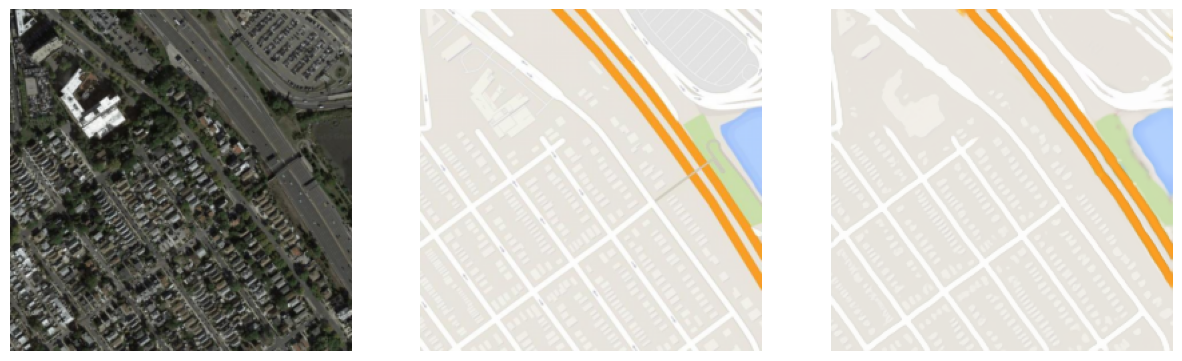

In [ ]:
next(gen)

In [ ]:
train_dataset[0][1]

(tensor([[[-0.7400, -0.6536, -0.7180,  ..., -0.4046, -0.5211, -0.4739],
          [-0.7391, -0.7658, -0.7539,  ..., -0.5614, -0.2835, -0.3151],
          [-0.7590, -0.8254, -0.8139,  ..., -0.6790, -0.4521, -0.2231],
          ...,
          [-0.8160, -0.8118, -0.7413,  ..., -0.5060, -0.4787, -0.4375],
          [-0.7917, -0.7882, -0.7237,  ..., -0.6940, -0.5205, -0.5071],
          [-0.7682, -0.7267, -0.4329,  ..., -0.4830, -0.4357, -0.4338]],
 
         [[-0.7314, -0.6388, -0.6944,  ..., -0.4046, -0.5211, -0.4739],
          [-0.7244, -0.7435, -0.7304,  ..., -0.5614, -0.2835, -0.3151],
          [-0.7250, -0.7924, -0.7865,  ..., -0.6790, -0.4521, -0.2231],
          ...,
          [-0.8082, -0.8040, -0.7334,  ..., -0.5146, -0.4877, -0.4458],
          [-0.7838, -0.7803, -0.7159,  ..., -0.7018, -0.5283, -0.5149],
          [-0.7604, -0.7189, -0.4251,  ..., -0.4908, -0.4435, -0.4416]],
 
         [[-0.7946, -0.7003, -0.7493,  ..., -0.4830, -0.5995, -0.5523],
          [-0.7906, -0.8088,